# Colon cancer detection with artificial inteligence

Artificial inteligence (AI) has shown its potential in multiple fields, including image classification. Massive models like ResNet50 can classify thousands of distinct regular entities like cars or animals, and were trained with millions of labelled images. However, its applications can go further its initial objectives with a methodology known as *transfer learning* (TL). With TL we can re-orient a powerfull model like ResNet50 towards a classification problem of our interest. In this notebook we make use of this model applying TL to classify histological images of normal and cancerous colon tissue.

The images used to train this model were obtaind from the [dataset](https://arxiv.org/abs/1912.12142v1) prepared by Borkowski et al., 2019.

## Install and import required library TensorFlow

In [ ]:
! pip install tensorflow

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam  
from __future__ import absolute_import, division, print_function, unicode_literals

2023-06-04 10:37:41.469447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 10:37:41.876404: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Compare two models

Let's compare two approaches, one applying the ResNet50 without additional training, and a second one using the ResNet50 model but with additional training with our histological colon images.

### Original model

In [27]:
# Define original model
model_original = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(768,768,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model_original.add(pretrained_model)
model_original.add(Flatten())
model_original.add(layers.Dense(2, activation='softmax'))

model_original.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

### Transfer learning model

In [2]:
# Define Transfer learning model
model_TL = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(768,768,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model_TL.add(pretrained_model)
model_TL.add(Flatten())
model_TL.add(layers.Dense(128, activation='relu'))
model_TL.add(layers.Dense(64, activation='relu'))
model_TL.add(layers.Dense(2, activation='softmax'))

model_TL.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Load weights
! wget https://drive.google.com/u/0/uc?id=1OYLgB_j_TXm0DqsHQ8mDPv6gr3lMyMAS&export=download
! mv uc?id=1OYLgB_j_TXm0DqsHQ8mDPv6gr3lMyMAS Tfl_ResNet50_Colon.h5
model_TL.load_weights('Tfl_ResNet50_Colon.h5')

2023-06-04 10:39:00.303809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In the previous code cell, we loaded weights to the transfer learning model **which has already been trained**. It was done using 9800 histological images of healthy and cancerous colon tissue. <br>
<br>
In the following cell, we now load images the model has never seen before, that is test images.

### Load test images

In [ ]:
! wget https://github.com/marco-montesdeoca/Transfer_learning/raw/main/colon_test.rar
! wget https://raw.githubusercontent.com/marco-montesdeoca/Transfer_learning/main/colonca1.jpeg
! unrar x colon_test.rar

In [6]:
test_dir = './colon_test/'
# Load images
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(768, 768),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)
# Store data as X and y arrays
X_test = list()
y_test = list()
for x_32, y_32 in test_data:
    for x in x_32:
        X_test.append(x)
    for y in y_32:
        y_test.append(y)
X_test_array = np.asarray(X_test) # X array store pixel data
y_test_array = np.asarray(y_test) # y array store labeling data

### Compare model predictions

We can now compare the prediction accuracy of the two models. Let's first check the original model, where no additional training was done.

In [39]:
# Original model prediction (takes ~ 30 seconds)
p_model_original_X_test = model_original.predict(X_test_array, batch_size=16)
correct_original = 0
for i in range(len(y_test_array)):
    target = y_test_array[i]
    prediction = np.argmax(p_model_original_X_test[i])
    if target == prediction:
        correct_original += 1
print(f'Accuracy percentage of original model: {(correct_original*100)/len(y_test_array)}')

7/7 [==============================] - 24s 3s/step
Accuracy percentage of original model: 47.0


47% accuracy... that's similar to tossing a coin. <br>
<br>
Now let's see how the transfer learning model does.

In [40]:
# Transfer learning model prediction (takes ~ 30 seconds)
p_model_TL_X_test = model_TL.predict(X_test_array, batch_size=16)
correct_TL = 0
for i in range(len(y_test_array)):
    target = y_test_array[i]
    prediction = np.argmax(p_model_TL_X_test[i])
    if target == prediction:
        correct_TL += 1
print(f'Accuracy percentage of transfer learning model: {(correct_TL*100)/len(y_test_array)}')

7/7 [==============================] - 24s 3s/step
Accuracy percentage of transfer learning model: 99.0


99% accuracy... now we are talking! <br>
<br>
Let's plot this finding:    

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
# creating summary dataset
data = {'Original model':47, 'Transfer learning':99}
models = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, values, color ='tab:blue',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Transfer learning impact in cancer detection \n with histological images")
plt.show()

### Single image test

Finally let's do a final test with a single image of cancerous colon tissue:

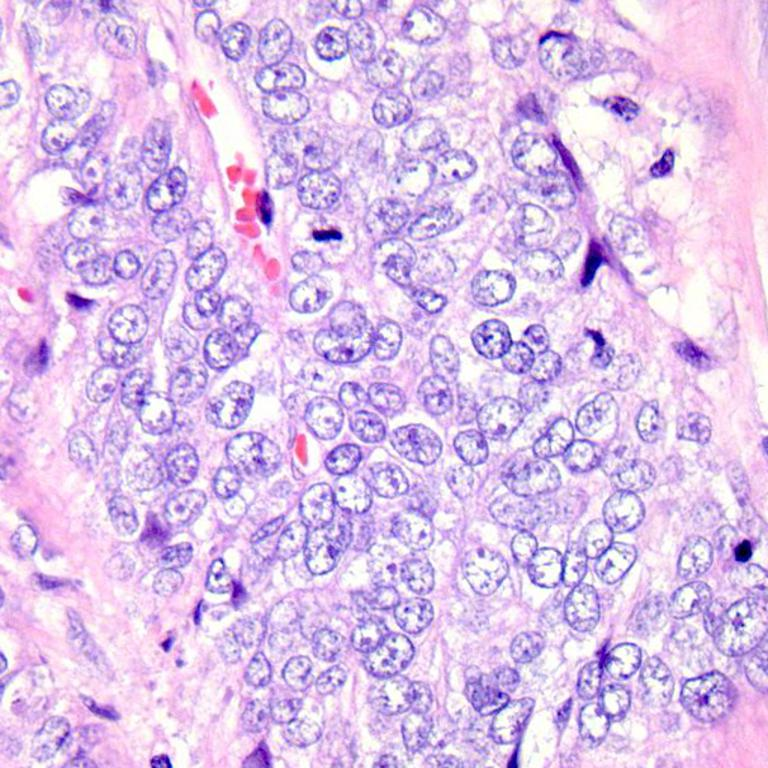

In [51]:
# Display histological image of cancerous colon tissue
from IPython.display import Image, display
display(Image(filename='colonca1.jpeg', width=300))

In [49]:
# Load and predict its condition
image = tf.keras.utils.load_img('colonca1.jpeg')
input_arr = tf.keras.utils.img_to_array(image)
test1 = [input_arr]
test1_array = np.array(test1)
p_model_TL_X_test_1 = model_TL.predict(test1_array, batch_size=16)
print(f'Prediction: {test_data.class_names[np.argmax(p_model_TL_X_test_1[0])]}')

1/1 [==============================] - 0s 301ms/step
Prediction: cancer_colon
